# EU AI Act Compliance Demo (Healthcare) — Colab Notebook v2
Now includes **extra teaching outputs**: confusion matrix, classification report table, ROC/PR curves, calibration, threshold sweep, and a simple fairness snapshot.


## 0) Setup

In [6]:
!pip install scikit-learn pandas matplotlib --quiet

In [7]:
import json, os, datetime, uuid, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             precision_recall_curve, average_precision_score, brier_score_loss)
from sklearn.calibration import calibration_curve
print('Environment ready ✅')

Environment ready ✅


## 1) Simulate Dataset

In [8]:
import numpy as np

rng = np.random.default_rng(42)
n = 600
df = pd.DataFrame({
    'age': rng.integers(20, 90, size=n),
    'bmi': rng.normal(27, 5, size=n).clip(15, 55),
    'blood_pressure': rng.normal(120, 15, size=n).clip(80, 200),
    'cholesterol': rng.normal(200, 30, size=n).clip(100, 350),
    'smoker': rng.integers(0, 2, size=n),
    'sex': rng.integers(0, 2, size=n)
})
risk_score = (0.02*df['age'] + 0.08*df['bmi'] + 0.015*df['blood_pressure']
              + 0.01*df['cholesterol'] + 0.5*df['smoker'] + 0.05*df['sex']
              + rng.normal(0, 1, size=n))
th = np.percentile(risk_score, 65)
df['risk_label'] = (risk_score > th).astype(int)
df.head()

,age,bmi,blood_pressure,cholesterol,smoker,sex,risk_label
0,26,25.539144,82.474502,209.851039,1,0,0
1,74,26.482559,94.440107,205.362229,0,1,0
2,65,25.740113,107.504449,181.511207,0,0,1
3,50,27.762813,111.634067,199.319442,1,1,1
4,50,34.357460,113.874171,181.323795,0,0,0


## 2) Train & Predict

In [9]:
X = df[['age','bmi','blood_pressure','cholesterol','smoker','sex']]
y = df['risk_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
clf = RandomForestClassifier(random_state=7)
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred, zero_division=0)
rec = recall_score(y_test, pred, zero_division=0)
f1 = f1_score(y_test, pred, zero_division=0)
print(f"Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")

fi = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_})       .sort_values('importance', ascending=False)
fi

Accuracy: 0.687  Precision: 0.537  Recall: 0.440  F1: 0.484


,feature,importance
0,age,0.261955
3,cholesterol,0.238473
1,bmi,0.228843
2,blood_pressure,0.201077
4,smoker,0.042606
5,sex,0.027046


## 3) Explainability Plot

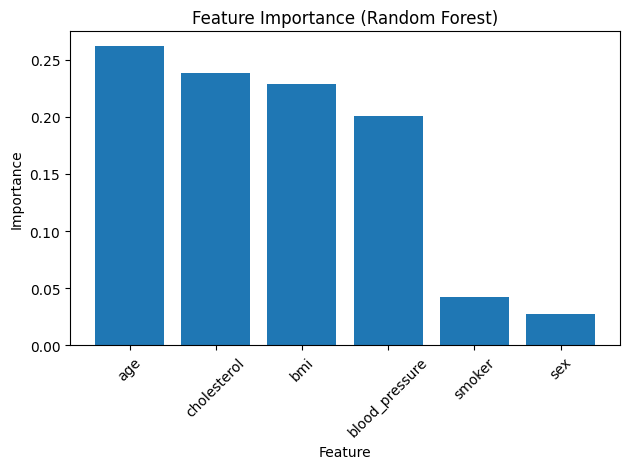

In [10]:
plt.figure()
plt.bar(fi['feature'], fi['importance'])
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4) Confusion Matrix & Classification Report

In [11]:
cm = confusion_matrix(y_test, pred, labels=[0,1])
print('Confusion matrix (rows=true, cols=pred):\n', cm)
cr = classification_report(y_test, pred, zero_division=0)
print("\nClassification report:\n", cr)

cr_df = pd.DataFrame(classification_report(y_test, pred, output_dict=True, zero_division=0)).T.reset_index()
cr_df.rename(columns={'index':'class_or_metric'}, inplace=True)
cr_df

Confusion matrix (rows=true, cols=pred):
 [[81 19]
 [28 22]]

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.81      0.78       100
           1       0.54      0.44      0.48        50

    accuracy                           0.69       150
   macro avg       0.64      0.62      0.63       150
weighted avg       0.67      0.69      0.68       150



,class_or_metric,precision,recall,f1-score,support
0,0,0.743119,0.810000,0.775120,100.000000
1,1,0.536585,0.440000,0.483516,50.000000
2,accuracy,0.686667,0.686667,0.686667,0.686667
3,macro avg,0.639852,0.625000,0.629318,150.000000
4,weighted avg,0.674275,0.686667,0.677919,150.000000


## 5) ROC & PR Curves + AUC/AP

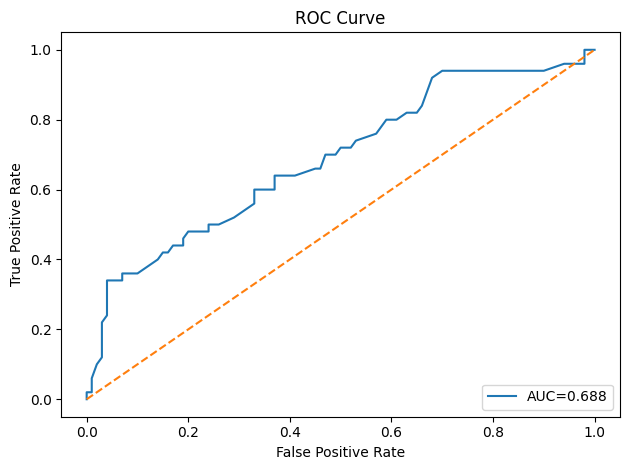

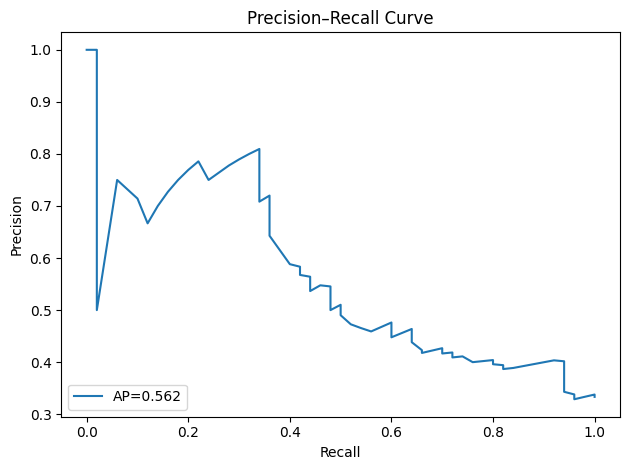

In [12]:
fpr, tpr, roc_thresh = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],linestyle='--')
plt.title("ROC Curve"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

prec_curve, rec_curve, pr_thresh = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)
plt.figure(); plt.plot(rec_curve, prec_curve, label=f"AP={ap:.3f}")
plt.title("Precision–Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(loc='lower left'); plt.tight_layout(); plt.show()

## 6) Calibration Curve + Brier Score

Brier score: 0.2033


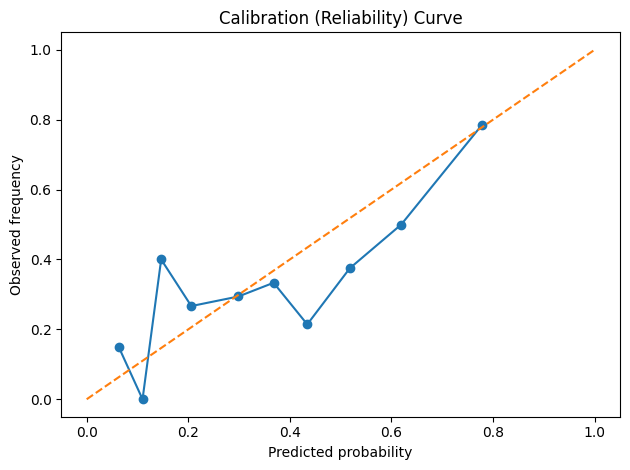

In [13]:
prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10, strategy='quantile')
brier = brier_score_loss(y_test, proba)
print("Brier score:", round(brier, 4))
plt.figure(); plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],linestyle='--')
plt.title("Calibration (Reliability) Curve"); plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.tight_layout(); plt.show()

## 7) Threshold Sweep (Search best F1)

In [14]:
ths = np.linspace(0.1, 0.9, 17)
rows = []
for t in ths:
    p = (proba >= t).astype(int)
    rows.append({
        "threshold": round(float(t), 2),
        "accuracy": accuracy_score(y_test, p),
        "precision": precision_score(y_test, p, zero_division=0),
        "recall": recall_score(y_test, p, zero_division=0),
        "f1": f1_score(y_test, p, zero_division=0),
        "positives_rate": p.mean()
    })
th_df = pd.DataFrame(rows)
best_row = th_df.sort_values("f1", ascending=False).head(1)
best_row, th_df

(   threshold  accuracy  precision  recall        f1  positives_rate
 5       0.35  0.633333   0.463768    0.64  0.537815            0.46,
     threshold  accuracy  precision  recall        f1  positives_rate
 0        0.10  0.426667   0.361538    0.94  0.522222        0.866667
 1        0.15  0.506667   0.388889    0.84  0.531646        0.720000
 2        0.20  0.526667   0.396040    0.80  0.529801        0.673333
 3        0.25  0.560000   0.411111    0.74  0.528571        0.600000
 4        0.30  0.586667   0.426829    0.70  0.530303        0.546667
 5        0.35  0.633333   0.463768    0.64  0.537815        0.460000
 6        0.40  0.633333   0.459016    0.56  0.504505        0.406667
 7        0.45  0.666667   0.500000    0.48  0.489796        0.320000
 8        0.50  0.686667   0.536585    0.44  0.483516        0.273333
 9        0.55  0.720000   0.642857    0.36  0.461538        0.186667
 10       0.60  0.740000   0.739130    0.34  0.465753        0.153333
 11       0.65  0.740

## 8) Fairness Snapshot by Sex (selection rate, TPR, FPR)

In [15]:
def rates_for_mask(mask, y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask], labels=[0,1]).ravel()
    sr = y_pred[mask].mean()
    tpr = tp / (tp+fn) if (tp+fn) else 0.0
    fprate = fp / (fp+tn) if (fp+tn) else 0.0
    return sr, tpr, fprate

sex0 = (X_test['sex'] == 0).to_numpy()
sex1 = (X_test['sex'] == 1).to_numpy()
sr0, tpr0, fpr0 = rates_for_mask(sex0, y_test.to_numpy(), pred)
sr1, tpr1, fpr1 = rates_for_mask(sex1, y_test.to_numpy(), pred)

fair_df = pd.DataFrame([
    {"group": "sex=0", "selection_rate": sr0, "TPR": tpr0, "FPR": fpr0},
    {"group": "sex=1", "selection_rate": sr1, "TPR": tpr1, "FPR": fpr1},
])
fair_df["selection_rate_gap"] = fair_df["selection_rate"] - fair_df["selection_rate"].mean()
fair_df

,group,selection_rate,TPR,FPR,selection_rate_gap
0,sex=0,0.315068,0.545455,0.215686,0.040651
1,sex=1,0.233766,0.357143,0.163265,-0.040651


## 9) Metrics Dashboard — One-Glance Status
Quick policy checks: Accuracy, F1, ROC AUC, Brier score (calibration), and selection-rate gap by sex.
Edit the `POLICY` dict to fit your classroom or org standards.


In [16]:
# Build and show a compact metrics dashboard
POLICY = {
    "min_accuracy": 0.60,
    "min_f1": 0.40,
    "min_auc": 0.70,
    "max_brier": 0.25,
    "max_selection_rate_gap": 0.20,
}
from sklearn.metrics import confusion_matrix, roc_curve, auc, brier_score_loss, average_precision_score

def rates_for_mask(mask, y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask], labels=[0,1]).ravel()
    sr = y_pred[mask].mean()
    tprate = tp / (tp+fn) if (tp+fn) else 0.0
    fprate = fp / (fp+tn) if (fp+tn) else 0.0
    return sr, tprate, fprate

proba = clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, zero_division=0)
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)
brier = brier_score_loss(y_test, proba)

sex0 = (X_test['sex'] == 0).to_numpy()
sex1 = (X_test['sex'] == 1).to_numpy()
sr0, tpr0, fpr0 = rates_for_mask(sex0, y_test.to_numpy(), pred)
sr1, tpr1, fpr1 = rates_for_mask(sex1, y_test.to_numpy(), pred)
sr_gap = float(abs(sr0 - sr1))

def status(pass_bool): return "✅ Pass" if pass_bool else "❌ Fail"

dashboard = pd.DataFrame([
    {"check": "Accuracy ≥ 0.60", "value": round(acc,3), "status": status(acc >= POLICY["min_accuracy"])},
    {"check": "F1 ≥ 0.40", "value": round(f1,3), "status": status(f1 >= POLICY["min_f1"])},
    {"check": "ROC AUC ≥ 0.70", "value": round(roc_auc,3), "status": status(roc_auc >= POLICY["min_auc"])},
    {"check": "Brier ≤ 0.25", "value": round(brier,3), "status": status(brier <= POLICY["max_brier"])},
    {"check": "Selection-rate gap (sex) ≤ 0.20", "value": round(sr_gap,3), "status": status(sr_gap <= POLICY["max_selection_rate_gap"])},
])
dashboard

,check,value,status
0,Accuracy ≥ 0.60,0.687,✅ Pass
1,F1 ≥ 0.40,0.484,✅ Pass
2,ROC AUC ≥ 0.70,0.688,❌ Fail
3,Brier ≤ 0.25,0.203,✅ Pass
4,Selection-rate gap (sex) ≤ 0.20,0.081,✅ Pass


# Demo 6: Explore EU AI Act Compliance in Healthcare AI

**Objective:** Simulate compliance with the EU AI Act by: (1) mapping system risk levels to actions, (2) logging model explainability, and (3) exporting structured documentation for audit.

---

## Task 1: Define risk categories
Map system risk levels to required governance actions, and simulate a current system's risk.


In [17]:
# Task 1: Define risk categories (EU AI Act demo)
risk_map = {
    "Unacceptable": "Prohibited – cannot be deployed (e.g., social scoring)",
    "High": "Audit Logs + Bias Monitoring + External Review",
    "Limited": "Transparency obligations (e.g., user disclosure)",
    "Minimal": "No significant requirements",
}

# Simulate current system risk selection
system_risk = "High"
print("Actions Required:", risk_map[system_risk])

Actions Required: Audit Logs + Bias Monitoring + External Review


## Task 2: Log explainability artifacts
Train a simple model and compute permutation feature importance to log explainability, per EU AI Act transparency requirements.


In [18]:
# Task 2: Explainability logging with RandomForest + Iris + permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.inspection import permutation_importance

data = load_iris()
clf = RandomForestClassifier().fit(data.data, data.target)
result = permutation_importance(clf, data.data, data.target, n_repeats=10, random_state=42)

# Log feature importances as a dict {feature_name: importance_mean}
importances = dict(zip(data.feature_names, result.importances_mean))
print("Feature importances:", importances)

Feature importances: {'sepal length (cm)': np.float64(0.007333333333333336), 'sepal width (cm)': np.float64(0.010666666666666668), 'petal length (cm)': np.float64(0.27199999999999996), 'petal width (cm)': np.float64(0.14533333333333334)}


## Task 3: Export documentation
Generate structured, auditable JSON documentation summarizing model metadata and governance info.


In [20]:
# Task 3: Export EU AI Act compliance documentation to JSON
from datetime import datetime
import json

doc = {
    "model_version": "1.0.2",
    "risk_level": system_risk,
    "features_used": list(data.feature_names),
    "feature_importance": importances,
    "system_use_case": "Hospital readmission risk prediction",
    "compliance_checked": True,
    "timestamp": datetime.now().isoformat(),
    "responsible_contact": {
        "name": "Your Name",
        "email": "Your EMail"
    }
}

with open("eu_compliance_doc.json", "w") as f:
    json.dump(doc, f, indent=2)

print("Wrote eu_compliance_doc.json with", len(doc), "top-level fields")

Wrote eu_compliance_doc.json with 8 top-level fields


---

**Done.** Run the cells above (in order) to produce `eu_compliance_doc.json`.  
This notebook is aligned to the three tasks specified in the Demo 6 guide.